In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# 注意文件夹名称（cs231n 后面有空格）
FOLDERNAME = 'cs231n  /assignments/assignment2'
assert FOLDERNAME is not None, "[! ] Enter the foldername."

import sys
import os

# 添加到系统路径
sys.path.append(f'/content/drive/MyDrive/{FOLDERNAME}')

# 切换到 cs231n/datasets 目录（注意这里要加 cs231n/）
datasets_path = f'/content/drive/MyDrive/{FOLDERNAME}/cs231n/datasets'
os.chdir(datasets_path)
! bash get_coco_dataset.sh

# 回到 assignment2 目录
os. chdir(f'/content/drive/MyDrive/{FOLDERNAME}')

Mounted at /content/drive


# Image Captioning with RNNs
In this exercise, you will implement vanilla Recurrent Neural Networks and use them to train a model that can generate novel captions for images.

In [2]:

# Setup cell.
import time, os, json
import numpy as np
import torch
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers_pytorch import *
from cs231n.captioning_solver_pytorch import CaptioningSolverPytorch
from cs231n.classifiers.rnn_pytorch import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

**Image features.** We have preprocessed the data and extracted features for you already. For all images, we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet, and these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5`. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512 using Principal Component Analysis (PCA), and these features are stored in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`. The raw images take up nearly 20GB of space so we have not included them in the download. Since all images are taken from Flickr, we have stored the URLs of the training and validation images in the files `train2014_urls.txt` and `val2014_urls.txt`. This allows you to download images on-the-fly for visualization.

**Captions.** Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `cs231n/coco_utils.py` to convert NumPy arrays of integer IDs back into strings.

**Tokens.** There are a couple special tokens that we add to the vocabulary, and we have taken care of all implementation details around special tokens for you. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

You can load all of the COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `cs231n/coco_utils.py`. Run the following cell to do so:

In [3]:
# Load COCO data from disk into a dictionary.
# We'll work with dimensionality-reduced features for the remainder of this assignment,
# but you can also experiment with the original features on your own by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/MyDrive/cs231n  /assignments/assignment2/cs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Inspect the Data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `cs231n/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

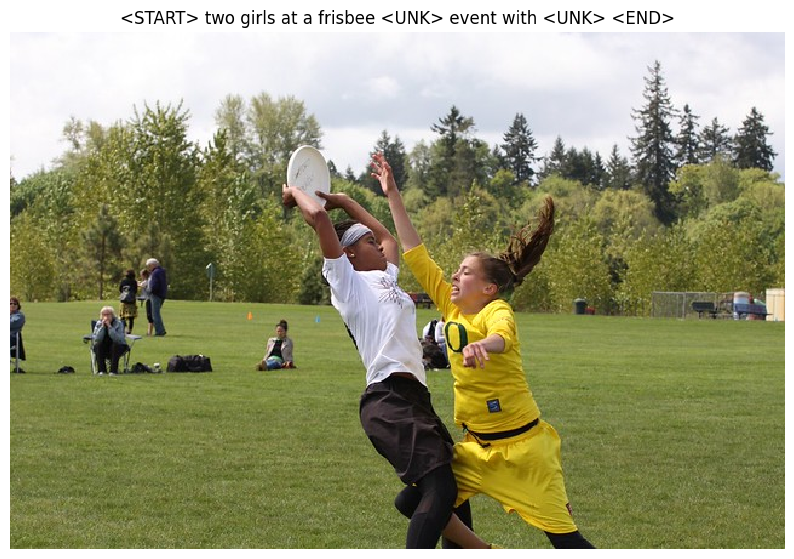

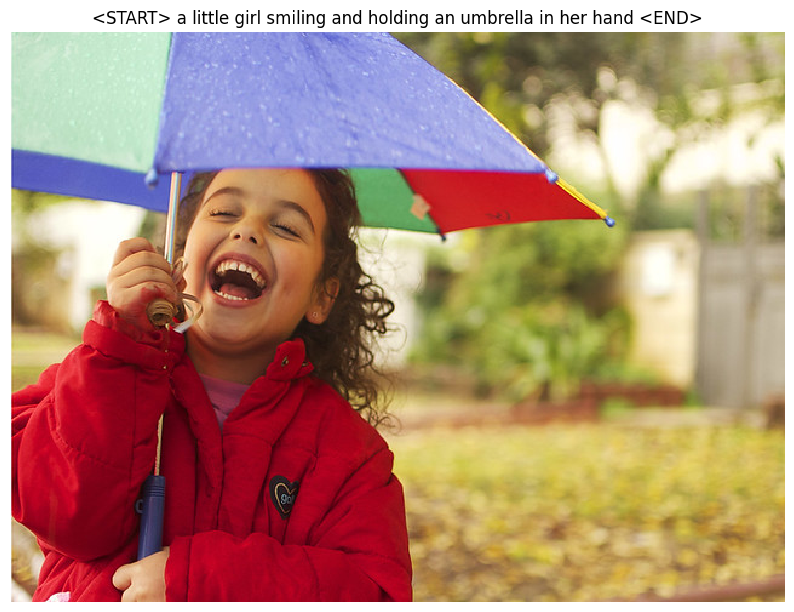

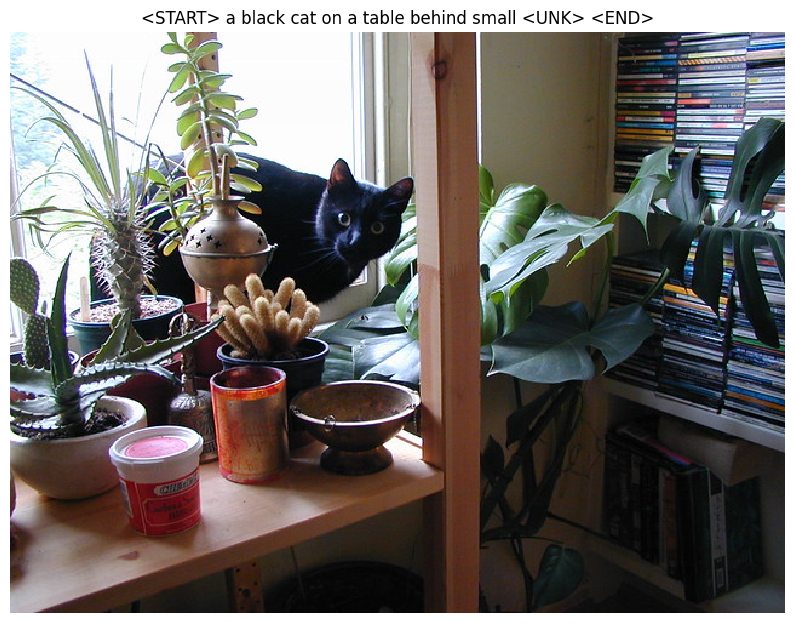

In [6]:
# Sample a minibatch and show the images and captions.
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Network
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. The file `cs231n/rnn_layers_pytorch.py` contains implementations of different layer types that are needed for recurrent neural networks, and the file `cs231n/classifiers/rnn_pytorch.py` uses these layers to implement an image captioning model.

We will first implement different types of RNN layers in `cs231n/rnn_layers_pytorch.py`.

# Vanilla RNN: Step Forward
Open the file `cs231n/rnn_layers_pytorch.py`. This file implements the forward passes for different types of layers that are commonly used in recurrent neural networks. Note that since we use pytorch, the backward pass will be handled by pytorch's autograd.

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors on the order of e-8 or less.

In [5]:
import torch

def affine_forward(x, w, b):
    out = x.reshape(x.shape[0], -1) @ w + b
    return out

def rnn_step_forward(x, prev_h, Wx, Wh, b):
    affline = x @ Wx + prev_h @ Wh + b
    next_h = torch.tanh(affline)
    return next_h

def rnn_forward(x, h0, Wx, Wh, b):
    N, T, D = x.shape
    H = h0.shape[1]
    h = torch.zeros((N, T, H), dtype=x.dtype, device=x.device)
    prev_h = h0
    for t in range(T):
        x_t = x[:, t, :]
        prev_h = rnn_step_forward(x_t, prev_h, Wx, Wh, b)
        h[:, t, :] = prev_h
    return h

def word_embedding_forward(x, W):
    out = W[x]
    return out

def sigmoid(x):
    return torch.sigmoid(x)

def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    # x: (N, D)
    # prev_h: (N, H)
    # prev_c: (N, H)
    # Wx: (D, 4H)
    # Wh: (H, 4H)
    # b: (4H,)
    H = prev_h.shape[1]
    a = x @ Wx + prev_h @ Wh + b  # (N, 4H)
    # Split activations
    ai = a[:, :H]
    af = a[:, H:2*H]
    ao = a[:, 2*H:3*H]
    ag = a[:, 3*H:4*H]
    i = sigmoid(ai)
    f = sigmoid(af)
    o = sigmoid(ao)
    g = torch.tanh(ag)
    next_c = f * prev_c + i * g  # (N, H)
    next_h = o * torch.tanh(next_c)  # (N, H)
    return next_h, next_c

def lstm_forward(x, h0, Wx, Wh, b):
    N, T, D = x.shape
    H = h0.shape[1]
    h = torch.zeros((N, T, H), dtype=x.dtype, device=x.device)
    prev_h = h0
    prev_c = torch.zeros((N, H), dtype=h0.dtype, device=h0.device)
    for t in range(T):
        x_t = x[:, t, :]
        next_h, next_c = lstm_step_forward(x_t, prev_h, prev_c, Wx, Wh, b)
        h[:, t, :] = next_h
        prev_h = next_h
        prev_c = next_c
    return h

def temporal_affine_forward(x, w, b):
    N, T, D = x.shape
    M = b.shape[0]
    out = (x.reshape(N * T, D) @ w).reshape(N, T, M) + b
    return out

def temporal_softmax_loss(x, y, mask, verbose=False):
    N, T, V = x.shape
    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    mask_flat = mask.reshape(N * T)
    loss = torch.nn.functional.cross_entropy(x_flat, y_flat, reduction='none')
    loss = loss * mask_flat.float()
    loss = loss.sum() / N
    return loss

In [7]:


N, D, H = 3, 10, 4

x = torch.from_numpy(np.linspace(-0.4, 0.7, num=N*D).reshape(N, D))
prev_h = torch.from_numpy(np.linspace(-0.2, 0.5, num=N*H).reshape(N, H))
Wx = torch.from_numpy(np.linspace(-0.1, 0.9, num=D*H).reshape(D, H))
Wh = torch.from_numpy(np.linspace(-0.3, 0.7, num=H*H).reshape(H, H))
b = torch.from_numpy(np.linspace(-0.2, 0.4, num=H))

next_h = rnn_step_forward(x, prev_h, Wx, Wh, b).numpy()
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: Step Backward
Since we implemented `rnn_step_forward` with pytorch, we do NOT have to implement `rnn_step_backward`. We can verify pytorch autograd backward
pass using our numerical gradient checker.

However, if you are feeling adventurous, you can try to implement `rnn_step_backward` yourself. It is not required in this assignment though.

In [8]:
def affine_forward(x, w, b):
    """Computes the forward pass for an affine (fully connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A torch array containing input data, of shape (N, d_1, ..., d_k)
    - w: A torch array of weights, of shape (D, M)
    - b: A torch array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    """
    out = x.reshape(x.shape[0], -1) @ w + b
    return out


def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """Run the forward pass for a single timestep of a vanilla RNN using a tanh activation function.

    The input data has dimension D, the hidden state has dimension H,
    and the minibatch is of size N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D)
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    """
    next_h = None
    ##############################################################################
    # TODO: Implement a single forward step for the vanilla RNN.                 #
    ##############################################################################
    affline=x@Wx+prev_h@Wh+b
    next_h=torch.tanh(affline)
    #
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h

np.random.seed(231)
N, D, H = 4, 5, 6
x = torch.from_numpy(np.random.randn(N, D))
h = torch.from_numpy(np.random.randn(N, H))
Wx = torch.from_numpy(np.random.randn(D, H))
Wh = torch.from_numpy(np.random.randn(H, H))
b = torch.from_numpy(np.random.randn(H))

# Enable gradient tracking and do rnn forward pass
for tensor in [x, h, Wx, Wh, b]:
  tensor.requires_grad_()
next_h = rnn_step_forward(x, h, Wx, Wh, b)

# Simulate random upstream gradients and do a backward pass using pytorch's
# autograd.
dnext_h = torch.from_numpy(np.random.randn(*next_h.shape))
next_h.backward(dnext_h)

# Collect gradient in separate numpy arrays
dx = x.grad.detach().numpy()
dh = h.grad.detach().numpy()
dWx = Wx.grad.detach().numpy()
dWh = Wh.grad.detach().numpy()
db = b.grad.detach().numpy()
dnext_h = dnext_h.detach().numpy()

# Also convert test inputs to numpy arrays
x =  x.detach().numpy()
h =  h.detach().numpy()
Wx = Wx.detach().numpy()
Wh = Wh.detach().numpy()
b =  b.detach().numpy()

# Wrap our forward pass to support numpy array input and output. We use
# `torch.no_grad()` to explicitly disable gradient tracking.
def rnn_step_forward_numpy(x, h, Wx, Wh, b):
  with torch.no_grad():
    return rnn_step_forward(
        torch.from_numpy(x),
        torch.from_numpy(h),
        torch.from_numpy(Wx),
        torch.from_numpy(Wh),
        torch.from_numpy(b),
    ).numpy()

# Compute numerical gradients and compare.
fx = lambda x: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fh = lambda h: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fWx = lambda Wx: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fWh = lambda Wh: rnn_step_forward_numpy(x, h, Wx, Wh, b)
fb = lambda b: rnn_step_forward_numpy(x, h, Wx, Wh, b)

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dh_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

# You should see errors on the order of 1e-9 or less
print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.319932372313319e-10
dh error:  2.682833932515051e-10
dWx error:  8.820301273669344e-10
dWh error:  4.703191244726939e-10
db error:  1.5956895526227225e-11


# Vanilla RNN: Forward
Now that you have implemented the forward for a single timestep of a vanilla RNN, you will use it to implement a RNN that processes an entire sequence of data.

In the file `cs231n/rnn_layers_pytorch.py`, implement the function `rnn_forward`. This should be implemented using the `rnn_step_forward` function that you defined above. After doing so run the following to check your implementation. You should see errors on the order of `e-7` or less.

In [9]:

def rnn_forward(x, h0, Wx, Wh, b):
    """Run a vanilla RNN forward on an entire sequence of data.

    We assume an input sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running the RNN forward,
    we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H)
    """
    h = None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    N, T, D = x.shape
    # 获取隐藏状态的维度H
    H = h0.shape[1]
    # 初始化一个全零张量，用于存储所有时间步的隐藏状态
    h = torch.zeros((N, T, H))
    # 将初始隐藏状态设置为h0
    prev_h = h0

    # 遍历序列中的每一个时间步
    for t in range(T):
        # 获取当前时间步的输入数据，形状为(N, D)
        x_t = x[:, t, :]
        # 调用rnn_step_forward计算当前时间步的隐藏状态
        prev_h = rnn_step_forward(x_t, prev_h, Wx, Wh, b)
        # 将当前时间步的隐藏状态存入结果张量中
        h[:, t, :] = prev_h
    #
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h

N, T, D, H = 2, 3, 4, 5

x = torch.from_numpy(np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D))
h0 = torch.from_numpy(np.linspace(-0.3, 0.1, num=N*H).reshape(N, H))
Wx = torch.from_numpy(np.linspace(-0.2, 0.4, num=D*H).reshape(D, H))
Wh = torch.from_numpy(np.linspace(-0.4, 0.1, num=H*H).reshape(H, H))
b = torch.from_numpy(np.linspace(-0.7, 0.1, num=H))

h = rnn_forward(x, h0, Wx, Wh, b).numpy()
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  6.737738559941792e-08


# Vanilla RNN: Backward
As before, we can verify pytorch autograd backward pass using our numerical gradient checker. You can also you can try to implement `rnn_step_backward` yourself if you want. It is not required in this assignment though.



In [10]:

def rnn_forward(x, h0, Wx, Wh, b):
    """Run a vanilla RNN forward on an entire sequence of data.

    We assume an input sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running the RNN forward,
    we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H)
    """
    h = None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    N, T, D = x.shape
    # 获取隐藏状态的维度H
    H = h0.shape[1]
    # 初始化一个全零张量，用于存储所有时间步的隐藏状态
    h = torch.zeros((N, T, H))
    # 将初始隐藏状态设置为h0
    prev_h = h0

    # 遍历序列中的每一个时间步
    for t in range(T):
        # 获取当前时间步的输入数据，形状为(N, D)
        x_t = x[:, t, :]
        # 调用rnn_step_forward计算当前时间步的隐藏状态
        prev_h = rnn_step_forward(x_t, prev_h, Wx, Wh, b)
        # 将当前时间步的隐藏状态存入结果张量中
        h[:, t, :] = prev_h
    #
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h


# Create test inputs
np.random.seed(231)
N, D, T, H = 2, 3, 10, 5
x = torch.from_numpy(np.random.randn(N, T, D))
h0 = torch.from_numpy(np.random.randn(N, H))
Wx = torch.from_numpy(np.random.randn(D, H))
Wh = torch.from_numpy(np.random.randn(H, H))
b = torch.from_numpy(np.random.randn(H))

# Enable gradient tracking and do forward pass
for tensor in [x, h0, Wx, Wh, b]:
  tensor.requires_grad_()
h = rnn_forward(x, h0, Wx, Wh, b)

# Simulate random upstream gradients and do a backward pass using pytorch's
# autograd.
dh = torch.from_numpy(np.random.randn(*h.shape))
h.backward(dh)

# Collect gradient in separate numpy arrays
dx = x.grad.detach().numpy()
dh0 = h0.grad.detach().numpy()
dWx = Wx.grad.detach().numpy()
dWh = Wh.grad.detach().numpy()
db = b.grad.detach().numpy()
dh = dh.detach().numpy()

# Also convert test inputs to numpy arrays
x =  x.detach().numpy()
h0 =  h0.detach().numpy()
Wx = Wx.detach().numpy()
Wh = Wh.detach().numpy()
b =  b.detach().numpy()

# Wrap our forward pass to support numpy array input and output. We use
# `torch.no_grad()` to explicitly disable gradient tracking.
def rnn_forward_numpy(x, h0, Wx, Wh, b):
  with torch.no_grad():
    return rnn_forward(
        torch.from_numpy(x),
        torch.from_numpy(h0),
        torch.from_numpy(Wx),
        torch.from_numpy(Wh),
        torch.from_numpy(b),
    ).numpy()


fx = lambda x: rnn_forward_numpy(x, h0, Wx, Wh, b)
fh0 = lambda h0: rnn_forward_numpy(x, h0, Wx, Wh, b)
fWx = lambda Wx: rnn_forward_numpy(x, h0, Wx, Wh, b)
fWh = lambda Wh: rnn_forward_numpy(x, h0, Wx, Wh, b)
fb = lambda b: rnn_forward_numpy(x, h0, Wx, Wh, b)

dx_num = eval_numerical_gradient_array(fx, x, dh)
dh0_num = eval_numerical_gradient_array(fh0, h0, dh)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dh)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dh)
db_num = eval_numerical_gradient_array(fb, b, dh)

# You should see errors on the order of 1e-6 or less
print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  0.13854911812376033
dh0 error:  0.05877079368098787
dWx error:  0.0837639128904392
dWh error:  0.037350760476429344
db error:  0.01789510129479967


# Word Embedding: Forward
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In the file `cs231n/rnn_layers_pytorch.py`, implement the function `word_embedding_forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see an error on the order of `e-8` or less.

In [11]:
def word_embedding_forward(x, W):
    out = None
    ##############################################################################
    # TODO: Implement the forward pass for word embeddings.                      #
    #                                                                            #
    # HINT: This can be done in one line using Pytorch's array indexing.         #
    ##############################################################################
    # 使用高级索引从权重矩阵W中选取x指定位置的词向量
    out = W[x]
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return out
N, T, V, D = 2, 4, 5, 3

x = torch.from_numpy(np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]]))
W = torch.from_numpy(np.linspace(0, 1, num=V*D).reshape(V, D))

out = word_embedding_forward(x, W).numpy()
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word Embedding: Backward
As before, we can verify pytorch autograd backward pass using our numerical gradient checker. You can also you can try to implement `word_embedding_backward` yourself if you want. It is not required in this assignment though.

In [12]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = torch.from_numpy(np.random.randint(V, size=(N, T)))
W = torch.from_numpy(np.random.randn(V, D))
W.requires_grad_()

out = word_embedding_forward(x, W)
dout = torch.from_numpy(np.random.randn(*out.shape))
out.backward(dout)

dW = W.grad.detach().numpy()
x = x.detach().numpy()
W = W.detach().numpy()
dout = dout.detach().numpy()

def word_embedding_forward_numpy(x, W):
  return word_embedding_forward(
      torch.from_numpy(x),
      torch.from_numpy(W),
  ).numpy()

f = lambda W: word_embedding_forward_numpy(x, W)
dW_num = eval_numerical_gradient_array(f, W, dout)

# You should see an error on the order of 1e-11 or less
print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


# Temporal Affine Layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. Because this is very similar to the affine layer that you implemented in assignment 2, we have provided this function for you in the `temporal_affine_forward`. Run the following to perform numeric gradient checking on the implementation. You should see errors on the order of `e-9` or less.

In [13]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = torch.from_numpy(np.random.randn(N, T, D))
w = torch.from_numpy(np.random.randn(D, M))
b = torch.from_numpy(np.random.randn(M))

for tensor in [x, w, b]:
  tensor.requires_grad_()
out = temporal_affine_forward(x, w, b)
dout = torch.from_numpy(np.random.randn(*out.shape))
out.backward(dout)

dx = x.grad.detach().numpy()
dw = w.grad.detach().numpy()
db = b.grad.detach().numpy()

x = x.detach().numpy()
w = w.detach().numpy()
b = b.detach().numpy()
dout = dout.detach().numpy()

def temporal_affine_forward_numpy(x, w, b):
  return temporal_affine_forward(
      torch.from_numpy(x),
      torch.from_numpy(w),
      torch.from_numpy(b),
  ).numpy()

fx = lambda x: temporal_affine_forward_numpy(x, w, b)
fw = lambda w: temporal_affine_forward_numpy(x, w, b)
fb = lambda b: temporal_affine_forward_numpy(x, w, b)

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  2.9215854231394017e-10
dw error:  1.5772088618663602e-10
db error:  3.252209560097257e-11


# Temporal Softmax Loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Since this is very similar to the softmax loss function you implemented in assignment 1, we have implemented this loss function for you; look at the `temporal_softmax_loss` function in the file `cs231n/rnn_layers_pytorch.py`.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx on the order of `e-7` or less.

In [14]:
# Sanity check for temporal softmax loss
from cs231n.rnn_layers_pytorch import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * torch.from_numpy(np.random.randn(N, T, V))
    y = torch.from_numpy(np.random.randint(V, size=(N, T)))
    mask = torch.from_numpy(np.random.rand(N, T)) <= p
    print(temporal_softmax_loss(x, y, mask).item())

check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be within 2.2-2.4

# Gradient check for temporal softmax loss
np.random.seed(231231)
N, T, V = 7, 8, 9

x = torch.from_numpy(np.random.randn(N, T, V))
y = torch.from_numpy(np.random.randint(V, size=(N, T)))
mask = torch.from_numpy(np.random.rand(N, T) > 0.5)

x.requires_grad_()
loss = temporal_softmax_loss(x, y, mask, verbose=False)
loss.backward()
dx = x.grad.detach().numpy()
x = x.detach().numpy()
dx_num = eval_numerical_gradient(
    lambda x: temporal_softmax_loss(torch.from_numpy(x), y, mask), x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027781774290146
23.02598595312723
2.2643611790293394
dx error:  5.5228696963589426e-08


# RNN for Image Captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. Open the file `cs231n/classifiers/rnn_pytorch.py` and look at the `CaptioningRNN` class.

Implement the forward pass of the model in the `loss` function. For now you only need to implement the case where `cell_type='rnn'` for vanilla RNNs; you will implement the LSTM case later. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-10` or less.

In [15]:
import torch

def affine_forward(x, w, b):
    out = x.reshape(x.shape[0], -1) @ w + b
    return out

def rnn_step_forward(x, prev_h, Wx, Wh, b):
    affline = x @ Wx + prev_h @ Wh + b
    next_h = torch.tanh(affline)
    return next_h

def rnn_forward(x, h0, Wx, Wh, b):
    N, T, D = x.shape
    H = h0.shape[1]
    h = torch.zeros((N, T, H), dtype=x.dtype, device=x.device)
    prev_h = h0
    for t in range(T):
        x_t = x[:, t, :]
        prev_h = rnn_step_forward(x_t, prev_h, Wx, Wh, b)
        h[:, t, :] = prev_h
    return h

def word_embedding_forward(x, W):
    out = W[x]
    return out

def sigmoid(x):
    return torch.sigmoid(x)

def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    # x: (N, D)
    # prev_h: (N, H)
    # prev_c: (N, H)
    # Wx: (D, 4H)
    # Wh: (H, 4H)
    # b: (4H,)
    H = prev_h.shape[1]
    a = x @ Wx + prev_h @ Wh + b  # (N, 4H)
    # Split activations
    ai = a[:, :H]
    af = a[:, H:2*H]
    ao = a[:, 2*H:3*H]
    ag = a[:, 3*H:4*H]
    i = sigmoid(ai)
    f = sigmoid(af)
    o = sigmoid(ao)
    g = torch.tanh(ag)
    next_c = f * prev_c + i * g  # (N, H)
    next_h = o * torch.tanh(next_c)  # (N, H)
    return next_h, next_c

def lstm_forward(x, h0, Wx, Wh, b):
    N, T, D = x.shape
    H = h0.shape[1]
    h = torch.zeros((N, T, H), dtype=x.dtype, device=x.device)
    prev_h = h0
    prev_c = torch.zeros((N, H), dtype=h0.dtype, device=h0.device)
    for t in range(T):
        x_t = x[:, t, :]
        next_h, next_c = lstm_step_forward(x_t, prev_h, prev_c, Wx, Wh, b)
        h[:, t, :] = next_h
        prev_h = next_h
        prev_c = next_c
    return h

def temporal_affine_forward(x, w, b):
    N, T, D = x.shape
    M = b.shape[0]
    out = (x.reshape(N * T, D) @ w).reshape(N, T, M) + b
    return out

def temporal_softmax_loss(x, y, mask, verbose=False):
    N, T, V = x.shape
    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    mask_flat = mask.reshape(N * T)
    loss = torch.nn.functional.cross_entropy(x_flat, y_flat, reduction='none')
    loss = loss * mask_flat.float()
    loss = loss.sum() / N
    return loss

In [16]:
import numpy as np
import torch


class CaptioningRNN:
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(
        self,
        word_to_idx,
        input_dim=512,
        wordvec_dim=128,
        hidden_dim=128,
        cell_type="rnn",
        dtype=torch.float32,
    ):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {"rnn", "lstm"}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx["<NULL>"]
        self._start = word_to_idx.get("<START>", None)
        self._end = word_to_idx.get("<END>", None)

        # Initialize word vectors
        self.params["W_embed"] = torch.randn(vocab_size, wordvec_dim)
        self.params["W_embed"] /= 100

        # Initialize CNN -> hidden state projection parameters
        self.params["W_proj"] = torch.randn(input_dim, hidden_dim)
        self.params["W_proj"] /= np.sqrt(input_dim)
        self.params["b_proj"] = torch.zeros(hidden_dim)

        # Initialize parameters for the RNN
        dim_mul = {"lstm": 4, "rnn": 1}[cell_type]
        self.params["Wx"] = torch.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params["Wx"] /= np.sqrt(wordvec_dim)
        self.params["Wh"] = torch.randn(hidden_dim, dim_mul * hidden_dim)
        self.params["Wh"] /= np.sqrt(hidden_dim)
        self.params["b"] = torch.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights
        self.params["W_vocab"] = torch.randn(hidden_dim, vocab_size)
        self.params["W_vocab"] /= np.sqrt(hidden_dim)
        self.params["b_vocab"] = torch.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.to(self.dtype)

    def loss(self, features, captions):
      features = features.to(self.dtype)
    # token, and the first element of captions_out will be the first word.
      captions_in = captions[:, :-1]
      captions_out = captions[:, 1:]

    # You'll need this
      mask = captions_out != self._null

    # Weight and bias for the affine transform from image features to initial
    # hidden state
      W_proj, b_proj = self.params["W_proj"], self.params["b_proj"]

    # Word embedding matrix
      W_embed = self.params["W_embed"]

    # Input-to-hidden, hidden-to-hidden, and biases for the RNN
      Wx, Wh, b = self.params["Wx"], self.params["Wh"], self.params["b"]

    # Weight and bias for the hidden-to-vocab transformation.
      W_vocab, b_vocab = self.params["W_vocab"], self.params["b_vocab"]

    # 1. Initial hidden state: affine transform
      h0 = features @ W_proj + b_proj  # shape (N, H)

    # 2. Word embedding
      x = W_embed[captions_in]  # shape (N, T, W)

    # 3. RNN/LSTM forward
      if self.cell_type == "rnn":
          h = rnn_forward(x, h0, Wx, Wh, b)  # (N, T, H)
      else:
          h = lstm_forward(x, h0, Wx, Wh, b)  # (N, T, H)

    # 4. Temporal affine transformation
      scores = temporal_affine_forward(h, W_vocab, b_vocab)  # (N, T, V)

    # 5. Temporal softmax loss
      loss = temporal_softmax_loss(scores, captions_out, mask)

      return loss

    def sample(self, features, max_length=30):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the input image features, and the initial word is the <START>
        token.

        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = features.shape[0]
        captions = self._null * torch.ones((N, max_length), dtype=torch.long)

        # Unpack parameters
        W_proj, b_proj = self.params["W_proj"], self.params["b_proj"]
        W_embed = self.params["W_embed"]
        Wx, Wh, b = self.params["Wx"], self.params["Wh"], self.params["b"]
        W_vocab, b_vocab = self.params["W_vocab"], self.params["b_vocab"]

        # (1) compute initial hidden state
        h = features @ W_proj + b_proj  # (N, H)

        if self.cell_type == "lstm":
            c = torch.zeros_like(h)  # (N, H) cell state for LSTM

        # (2) initialize the first word for each sample in minibatch: <START>
        prev_word = torch.tensor([self._start] * N, dtype=torch.long)

        for t in range(max_length):
            # (1) embed the previous word
            word_embed = W_embed[prev_word]  # (N, W)

            # (2) RNN/LSTM step
            if self.cell_type == "rnn":
                h, _ = rnn_step_forward(word_embed, h, Wx, Wh, b)
            else:
                h, c, _ = lstm_step_forward(word_embed, h, c, Wx, Wh, b)

            # (3) affine transformation to compute scores
            scores = h @ W_vocab + b_vocab  # (N, V)

            # (4) select the word with the highest score
            next_word = torch.argmax(scores, dim=1)  # (N,)

            captions[:, t] = next_word

            # (5) next input is current selected word for sampling
            prev_word = next_word

        return captions

In [17]:

N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type='rnn',
    dtype=torch.float64
)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = torch.from_numpy(
        np.linspace(-1.4, 1.3, num=v.numel()).reshape(*v.shape))

features = torch.from_numpy(np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D))
captions = torch.from_numpy((np.arange(N * T) % V).reshape(N, T))

loss = model.loss(features, captions).item()
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.83235591002739
expected loss:  9.83235591003
difference:  2.609468197078968e-12


Run the following cell to perform numeric gradient checking on the `CaptioningRNN` class; you should see errors around the order of `e-6` or less.

In [18]:
np.random.seed(231)
torch.manual_seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = torch.from_numpy(np.random.randint(vocab_size, size=(batch_size, timesteps)))
features = torch.from_numpy(np.random.randn(batch_size, input_dim))

model = CaptioningRNN(
    word_to_idx,
    input_dim=input_dim,
    wordvec_dim=wordvec_dim,
    hidden_dim=hidden_dim,
    cell_type='rnn',
    dtype=torch.float64,
)

for k, v in model.params.items():
  v.requires_grad_()
loss = model.loss(features, captions)
loss.backward()
grads = {k: v.grad.detach().numpy() for k, v in model.params.items()}
for k, v in model.params.items():
  v.requires_grad_(False)

for param_name in sorted(grads.keys()):
    def fn(val):
      model.params[param_name] = torch.from_numpy(val)
      ret = model.loss(features, captions).numpy()
      return ret

    param_grad_num = eval_numerical_gradient(
        fn, model.params[param_name].numpy(), verbose=False, h=1e-6)

    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 2.630824e-09
W_proj relative error: 5.778112e-08
W_vocab relative error: 1.309392e-08
Wh relative error: 1.762622e-09
Wx relative error: 8.072585e-06
b relative error: 8.450890e-10
b_proj relative error: 3.580123e-10
b_vocab relative error: 5.193917e-09


# Overfit RNN Captioning Model on Small Data
Similar to the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use a `CaptioningSolverPytorch` class to train image captioning models. Open the file `cs231n/captioning_solver_pytorch.py` and read through the `CaptioningSolverPytorch` class; it should look very familiar.

Once you have familiarized yourself with the API, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

base dir  /content/drive/MyDrive/cs231n  /assignments/assignment2/cs231n/datasets/coco_captioning
(Iteration 1 / 100) loss: 80.027161
(Iteration 11 / 100) loss: 25.581049
(Iteration 21 / 100) loss: 3.890460
(Iteration 31 / 100) loss: 0.641123
(Iteration 41 / 100) loss: 0.133215
(Iteration 51 / 100) loss: 0.057624
(Iteration 61 / 100) loss: 0.028611
(Iteration 71 / 100) loss: 0.022358
(Iteration 81 / 100) loss: 0.018526
(Iteration 91 / 100) loss: 0.016731


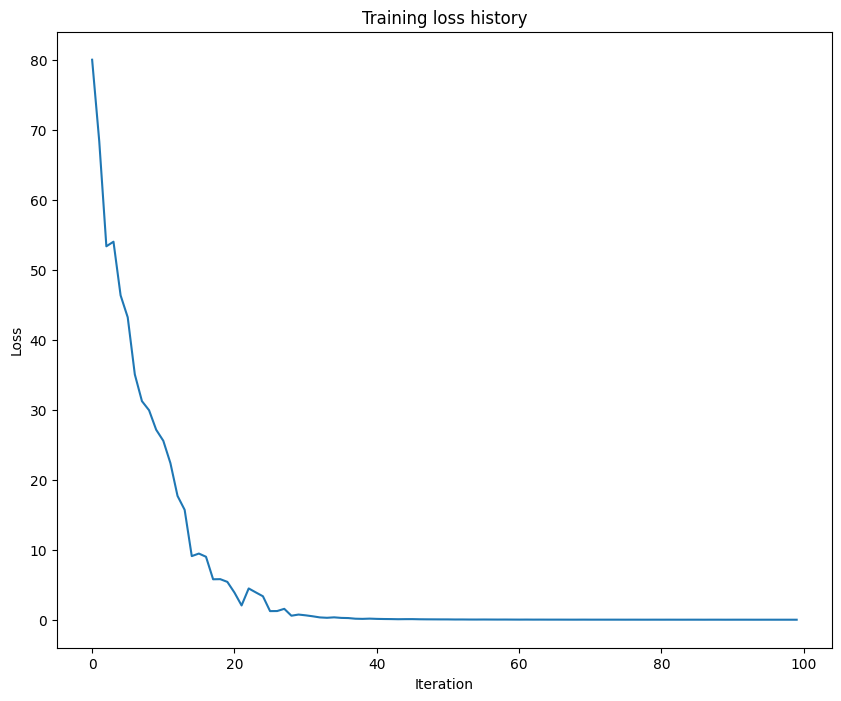

In [19]:
np.random.seed(231)
torch.manual_seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
    cell_type='rnn',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
)

small_rnn_solver = CaptioningSolverPytorch(
    small_rnn_model, small_data,
    num_epochs=50,
    batch_size=25,
    learning_rate=5e-3,
    verbose=True, print_every=10,
)

small_rnn_solver.train()

# Plot the training losses.
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.1.

In [20]:
print('Final loss: ', small_rnn_solver.loss_history[-1])

Final loss:  0.013372625


# RNN Sampling at Test Time
Unlike classification models, image captioning models behave very differently at training time vs. at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep and feed the sample as input to the RNN at the next timestep.

In the file `cs231n/classifiers/rnn_pytorch.py`, implement the `sample` method for test-time sampling. After doing so, run the following to sample from your overfitted model on both training and validation data. The samples on training data should be very good. The samples on validation data, however, probably won't make sense.

In [23]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(torch.from_numpy(features)).numpy()
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# Inline Question 1

In our current image captioning setup, our RNN language model produces a word at every timestep as its output. However, an alternate way to pose the problem is to train the network to operate over _characters_ (e.g. 'a', 'b', etc.) as opposed to words, so that at it every timestep, it receives the previous character as input and tries to predict the next character in the sequence. For example, the network might generate a caption like

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

Can you describe one advantage of an image-captioning model that uses a character-level RNN? Can you also describe one disadvantage? HINT: there are several valid answers, but it might be useful to compare the parameter space of word-level and character-level models.

**Your Answer:**
